In [1]:
# Eigenvector substitution (reduction to 2gen)
import sympy as sp
from functions import *
import numpy as np
from sympy.matrices import matrix_multiply_elementwise
import matplotlib.pyplot as plt

# sp.init_printing(use_latex="mathjax")
import matplotlib
from numerical import P_num_over_E_single as P_num

matplotlib.rc("text", usetex=False)
matplotlib.rc("text.latex", preamble=r"\usepackage{amsmath}")

m_21, m_31, m_41 = sp.symbols("dm_21 dm_31 dm_41")
th_12, th_13, th_23, th_34, th_23, th_14, th_24 = sp.symbols(
    "theta_12 theta_13 theta_23 theta_34 theta_23 theta_14 theta_24"
)
E = sp.symbols("E")
d_ij = sp.symbols("delta_ij")
(
    V_cc,
    V_nc,
) = sp.symbols("V_cc,V_nc")
(
    A_cc,
    A_nc,
) = sp.symbols("A_cc,A_nc")
param_dict_num = param_dict  # Regular dict with parameter values
param_dict_sym = {
    "theta_12": th_12,  # Symbolic dict with sympy symbols
    "theta_13": th_13,
    "theta_23": th_23,
    "theta_34": th_34,
    "theta_24": th_24,
    "theta_14": th_14,
    "delta_ij": d_ij,
    "dm_21": m_21,
    "dm_31": m_31,
    "dm_41": m_41,
}


def V_ijab(i, j, a, b, A=0, params=param_dict_sym):  # Blennow 78:807 delta_ij = 0
    if a == b:
        if a == i or a == j:
            return sp.cos(theta(i, j, A, params=params))
        else:
            return 1
    else:
        if a == i and b == j:
            return sp.sin(-theta(i, j, A, params=params))
        elif a == j and b == i:
            return -sp.sin(-theta(i, j, A, params=params))
        else:
            return 0


def V_matrix(i, j, A=0, n=0, params=param_dict_sym):  # Blennow 78:807
    result = sp.zeros(3 + n, 3 + n)
    for a in range(1, 4 + n):
        elem1 = [V_ijab(i, j, a, b, A, params=params) for b in range(1, 3 + n + 1)]
        result[a - 1] = elem1
    return result


def U_nu(ndim, A=0, params=param_dict_sym):
    if ndim == 4:
        return (
            V_matrix(3, 4, A, 1, params=params)
            @ V_matrix(2, 4, A, 1, params=params)
            @ V_matrix(1, 4, A, 1, params=params)
            @ V_matrix(2, 3, A, 1, params=params)
            @ V_matrix(1, 3, A, 1, params=params)
            @ V_matrix(1, 2, A, 1, params=params)
        )
    elif ndim == 3:
        return (
            V_matrix(2, 3, A, 0, params=params)
            @ V_matrix(1, 3, A, 0, params=params)
            @ V_matrix(1, 2, A, 0, params=params)
        )
    elif ndim == 2:  # sin blir -sin jmf med U i constants
        return V_matrix(1, 2, A, -1, params=params)

ModuleNotFoundError: No module named 'functions'

In [ ]:
# Define numeric parameters
full_params = {
    "dm_21": param_dict_num["dm_21"],
    "dm_31": param_dict_num["dm_31"],
    "dm_41": param_dict_num["dm_41"],
    "delta_ij": 0,
    "theta_12": param_dict_num["theta_12"],
    "theta_13": param_dict_num["theta_13"],
    "theta_23": param_dict_num["theta_23"],
    "theta_14": np.arcsin(np.sqrt(0)),
    "theta_24": np.arcsin(np.sqrt(0.04)),
    "theta_34": np.arcsin(np.sqrt(0)),
}
single_params = {
    "dm_21": 0,
    "dm_31": 0,
    "dm_41": param_dict_num["dm_41"],
    "delta_ij": 0,
    "theta_12": param_dict_num["theta_12"],
    "theta_13": param_dict_num["theta_13"],
    "theta_23": param_dict_num["theta_23"],
    "theta_14": np.arcsin(np.sqrt(0)),
    "theta_24": np.arcsin(np.sqrt(0.04)),
    "theta_34": np.arcsin(np.sqrt(0)),
}
V_cc = np.sqrt(2) * GF * 0.5 * N_A * 8.44 * (1 / GeVtocm1) ** 3  # GeV
V_nc = V_cc / 2  # GeV
single_params, full_params

In [3]:
def get_H_(En, params, mtype):
    """
    En in [GeV]
    """
    M = sp.diag(0, params["dm_21"], params["dm_31"], params["dm_41"])
    if mtype == "full":
        U = U_nu(4, params=params)
    elif mtype == "single":
        # assert np.isclose(params['dm_21'],0), 'H got single type, but params has masses!'
        # assert np.isclose(params['dm_31'],0), 'H got single type, but params has masses!'
        U = (
            V_matrix(3, 4, 0, 1, params=params)
            @ V_matrix(2, 4, 0, 1, params=params)
            @ V_matrix(1, 4, 0, 1, params=params)
        )
    A = sp.diag(2 * E * V_cc, 0, 0, 2 * E * V_nc)
    H = 1 / (2 * E * 1e9) * (U @ M @ U.T + A * 1e18)
    # if type(En) is sp.core.symbol.Symbol: #If energy numeric, return numeric H
    # H = H.evalf(subs={E:En}, chop=False)
    H = H.subs(E, En)
    return H


def diagonalize_H_(H):
    UM, HM = H.diagonalize(
        reals_only=False, sort=True, normalize=True
    )  # HM, or D, is the matter Hamiltonian, with dmM on its diagonal. UM, or P, is the U matrix in matter
    return UM, HM


def get_dmM_(HM, En):
    """
    En in [GeV]
    """
    eigenvals = HM * sp.Matrix([1, 1, 1, 1])
    dmM = 2 * E * 1e9 * eigenvals
    dmM = dmM.subs(E, En)
    return dmM


def get_Usquared_(UM):
    UM_squared = matrix_multiply_elementwise(UM, UM).transpose()
    UMe = UM_squared.row(0)
    UMm = UM_squared.row(1)
    UMt = UM_squared.row(2)
    UMs = UM_squared.row(3)
    return UMe, UMm, UMt, UMs


def get_dmM(En, params, mtype):
    """
    En in [GeV]
    """
    H = get_H_(En, params=params, mtype=mtype)
    UM, HM = diagonalize_H_(H)
    dmM = get_dmM_(HM, En)
    return dmM


def get_UMsq(En, params, mtype):
    """
    En in [GeV]
    """
    H = get_H_(En, params=params, mtype=mtype)
    UM, HM = diagonalize_H_(H)
    UMsq = get_Usquared_(UM)
    return UMsq


def get_UM(En, params, mtype):
    """
    En in [GeV]
    """
    H = get_H_(En, params=params, mtype=mtype)
    UM, HM = diagonalize_H_(H)
    return UM

In [4]:
E_range = np.logspace(3, 4, 50)
dmM = np.transpose([get_dmM(En, single_params, "single") for En in E_range])[0]

NameError: name 'np' is not defined

In [5]:
UMsq_single = np.transpose(
    [get_UMsq(En, single_params, mtype="single") for En in E_range]
)
UMsq_full = np.transpose([get_UMsq(En, full_params, mtype="full") for En in E_range])

Text(-0.02, 0.4, ' dm_21: 7.42e-05 \n dm_31: 0.002514 \n dm_41: -1 \n sin_14: 0.0 \n sin_24: 0.04 \n sin_34: 0.0 \n')

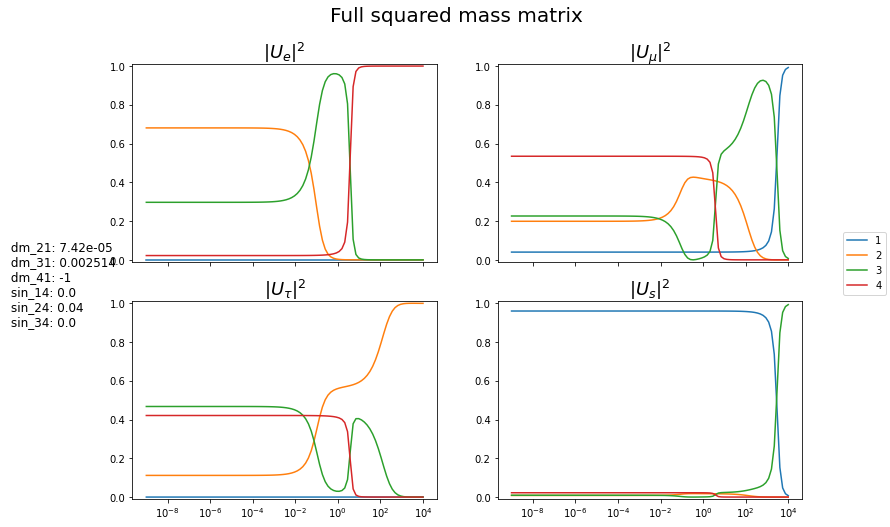

In [6]:
flavors = ["e", "\mu", "\\tau", "s"]
fig, ax = plt.subplots(2, 2, sharex=True)
fig.set_size_inches((12, 8))
ax = ax.flatten()
for i in range(4):
    ax[i].set_title(rf"$|U_{flavors[i]}|^2$", fontsize=18)
    ax[i].set_ylim((-0.01, 1.01))
    ax[i].set_xscale("log")
    for k in range(4):
        ax[i].plot(E_range, UMsq_full[i][0][k], label=k + 1)
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right")
fig.suptitle("Full squared mass matrix", fontsize=20)
str_param = f' dm_21: {full_params["dm_21"]} \n dm_31: {full_params["dm_31"]} \n dm_41: {full_params["dm_41"]} \n sin_14: {np.round(np.sin(full_params["theta_14"])**2,2)} \n sin_24: {np.round(np.sin(full_params["theta_24"])**2,2)} \n sin_34: {np.round(np.sin(full_params["theta_34"])**2,2)} \n'
plt.gcf().text(-0.02, 0.4, str_param, fontsize=12)

Text(-0.02, 0.4, ' dm_21: 0 \n dm_31: 0 \n dm_41: -1 \n sin_14: 0.0 \n sin_24: 0.04 \n sin_34: 0.0 \n')

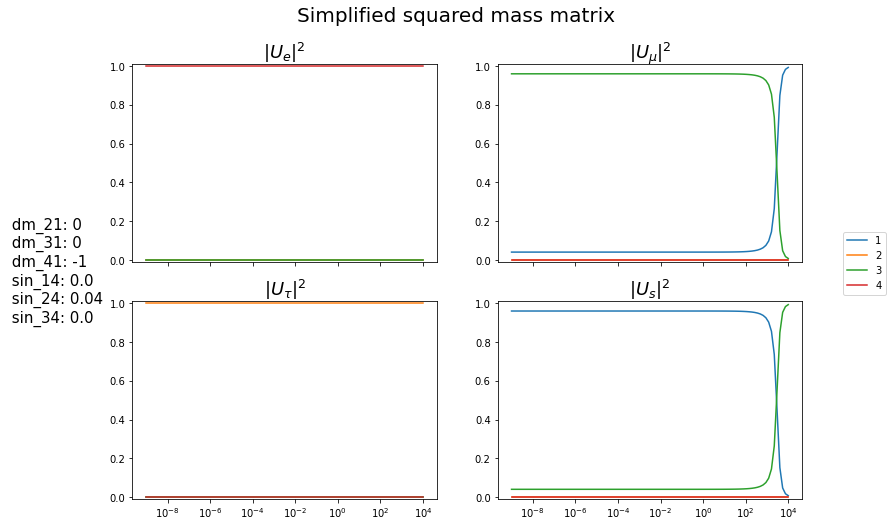

In [7]:
flavors = ["e", "\mu", "\\tau", "s"]
fig, ax = plt.subplots(2, 2, sharex=True)
fig.set_size_inches((12, 8))
ax = ax.flatten()
for i in range(4):
    ax[i].set_title(rf"$|U_{flavors[i]}|^2$", fontsize=18)
    ax[i].set_ylim((-0.01, 1.01))
    ax[i].set_xscale("log")
    for k in range(4):
        ax[i].plot(E_range, UMsq_single[i][0][k], label=k + 1)
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right")
fig.suptitle("Simplified squared mass matrix", fontsize=20)

# Show parameters
str_param = f' dm_21: 0 \n dm_31: 0 \n dm_41: {param_dict_num["dm_41"]} \n sin_14: {np.round(np.sin(param_dict_num["theta_14"])**2,2)} \n sin_24: {np.round(np.sin(param_dict_num["theta_24"])**2,2)} \n sin_34: {np.round(np.sin(param_dict_num["theta_34"])**2,2)} \n'
plt.gcf().text(-0.02, 0.4, str_param, fontsize=15)

In [12]:
def P_an_single(alpha, beta, En, L, params):
    dmM = np.asarray(get_dmM(En, params, "single")).astype(np.float64)
    UM_single = np.asarray(get_UM(En, params, "single")).astype(np.float64)
    Ufrom = UM_single[alpha]
    Uto = UM_single[beta]
    dm41 = dmM[0]
    dm21 = dmM[1]
    dm31 = dmM[2]
    dm11 = dmM[3]
    dmM = [dm11, dm21, dm31, dm41]  # reorder dmM
    params_with_dmM = params.copy()
    params_with_dmM.update({"dm_41": dmM[0], "dm_21": dmM[1], "dm_31": dmM[2]})
    P_list = []
    for k in range(0, 4):
        for j in range(0, k):  # 1605.08607 eq3, giunti 7.38 and 7.51
            m = dm(k + 1, j + 1, params=params_with_dmM)
            U_product = Ufrom[k] * Uto[k] * Ufrom[j] * Uto[j]
            real_part = U_product * np.sin(GeV2tokm1 * m * L / (4 * En)) ** 2
            P_list.append(real_part)
    if (Ufrom == Uto).all():
        return 1 - 4 * np.sum(P_list)
    else:
        return -4 * np.sum(P_list)

Text(0.5, 0.98, 'Oscillation probabilities')

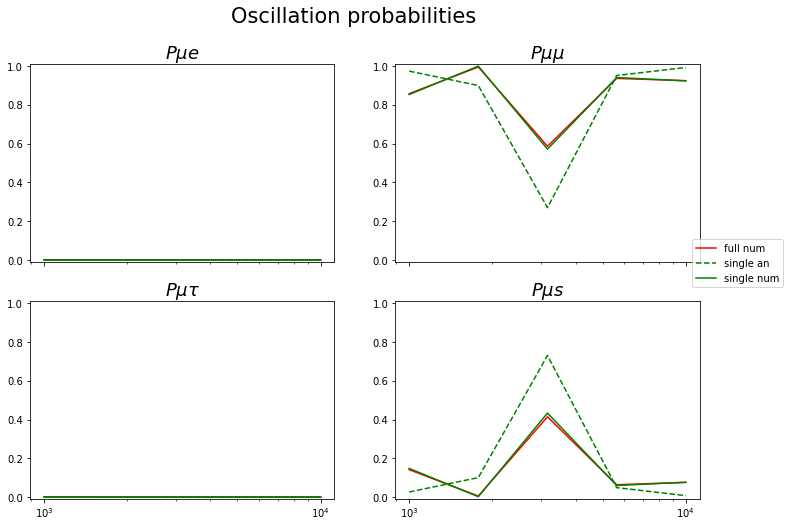

In [13]:
flavors = ["e", "\\mu", "\\tau", "s"]
E_range = np.logspace(3, 4, 5)

fig, ax = plt.subplots(2, 2, sharex=True)
fig.set_size_inches((12, 8))
ax = ax.flatten()

_, P_num_single = P_num(
    "m", E_range, ndim=4, params=single_params, vacuum=False, anti=True
)
_, P_num_full = P_num("m", E_range, ndim=4, params=full_params, vacuum=False, anti=True)

for i in range(4):
    ax[i].set_title(rf"$P\mu {flavors[i]}$", fontsize=18)
    ax[i].set_ylim((-0.01, 1.01))
    ax[i].set_xscale("log")
    P_an_list_single = []
    P_an_list_full = []
    for En in E_range:
        P_an_list_single.append(
            P_an_single(alpha=1, beta=i, En=En, L=2 * r_earth, params=single_params)
        )

    ax[i].plot(E_range, P_num_full[i], label="full num", c="r")
    ax[i].plot(E_range, P_an_list_single, label="single an", linestyle="--", c="g")
    ax[i].plot(E_range, P_num_single[i], label="single num", c="g")
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right")
fig.suptitle("Oscillation probabilities", fontsize=21)

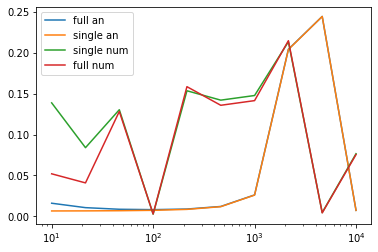

In [14]:
E_range = np.logspace(1, 4, 10)

P_an_list_single = []
P_an_list_full = []
for En in E_range:
    P_an_list_full.append(
        P_an_single(alpha=1, beta=3, En=En, L=2 * r_earth, params=full_params)
    )
    P_an_list_single.append(
        P_an_single(alpha=1, beta=3, En=En, L=2 * r_earth, params=single_params)
    )
_, P_num_single = P_num(
    "m", E_range, ndim=4, params=single_params, vacuum=False, anti=True
)
_, P_num_full = P_num("m", E_range, ndim=4, params=full_params, vacuum=False, anti=True)
plt.plot(E_range, P_an_list_full, label="full an")
plt.plot(E_range, P_an_list_single, label="single an")
plt.plot(E_range, P_num_single[3], label="single num")
plt.plot(E_range, P_num_full[3], label="full num")
plt.xscale("log")
plt.legend()

In [15]:
symb_params = param_dict_sym.copy()
symb_params.update(
    {
        "theta_12": param_dict_num["theta_12"],
        "theta_13": param_dict_num["theta_13"],
        "theta_23": param_dict_num["theta_23"],
        "theta_14": 0,
        "theta_24": param_dict_sym["theta_24"],
        "theta_34": 0,  # param_dict_sym['theta_34'],
        "dm_21": 0,
        "dm_31": 0,
        "dm_41": param_dict_sym["dm_41"],
    }
)

Matrix([
[3.22090090472949e-13,                                           0, 0,                                                           0],
[                   0,            5.0e-10*dm_41*sin(theta_24)**2/E, 0,                 5.0e-10*dm_41*sin(theta_24)*cos(theta_24)/E],
[                   0,                                           0, 0,                                                           0],
[                   0, 5.0e-10*dm_41*sin(theta_24)*cos(theta_24)/E, 0, 5.0e-10*(0.000322090090472949*E + dm_41*cos(theta_24)**2)/E]])

In [17]:
U_symb = get_UM(3e3, symb_params, "single")
Uproduct_Pmm = sp.simplify(U_symb[7] * U_symb[6] * U_symb[14] * U_symb[15])
Uproduct_Pmm